#### SimFLEX + ExMAS + MSA + OTP = KPI


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
# from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import random

import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
inData.G

In [5]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk_zones.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<Axes: >

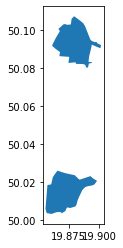

In [12]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas['name'] = gdf_areas['name'].replace('Bronowice Wielkie', 'Bronowice')
gdf_areas.plot()

In [13]:
gdf_areas

,name,geometry
0,Bronowice,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [8]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [9]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city graph
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [11]:
# Chosen hub locations for each area
hubs = {"Bronowice": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

##### Main simulations: evaluate primary indicators 

We run simulations with the following parameters:
<br>degree = 6, N = 100, max_iter = 30, results_period = 20
<br>
<br>KPIs:
- Probability of choosing feeder
- Reduction in waiting times for PT
- Feeder attractiveness
- Added value

In [14]:
results = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                     degree=6, N=1, max_iter=3, ASC=2.15, results_period=0)

replication 1 for area Bronowice
p_SUM  0.3467145388117472
iteration  1  for Bronowice
sum_demand sample 73
iteration  2  for Bronowice
sum_demand sample 73
iteration  3  for Bronowice
sum_demand sample 70
no convergence after 3 iterations
-----------------------------------------------------

replication 1 for area Skotniki
p_SUM  0.25609912052860556
iteration  1  for Skotniki
sum_demand sample 40
iteration  2  for Skotniki
sum_demand sample 44
iteration  3  for Skotniki
sum_demand sample 39
no convergence after 3 iterations
-----------------------------------------------------



For each area, Bronowice and Skotniki:
<br>dataframes "avg_sim_res" contain average main results for such variables:
- tw_PT_OD - waiting time for PT from O to D
- tw_PT_HD - waiting time for PT from H to D
- u_PT_OD - utility for PT option from O to D
- u_PT_HD - utility for PT option from H to D 
- u_SUM_OD - utility for feeder option from O to D
- p_SUM - probability of choosing feeder

In [15]:
# Example results
results['Bronowice']['avg_sim_res']
# results['Skotniki']['avg_sim_res']

,tw_PT_OD,tw_PT_HD,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM
0,119.933014,59.947368,13.687972,10.516836,16.475908,0.34061


dataframes "sum_res" contain results for 1 area sample replication:
<br>origin_x, origin_y, destination_x, destination_y, treq, origin, destination, 
<br>dist, ttrav, tarr, t_expected, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM, nTrips

In [16]:
results['Bronowice']['sum_res']
# results['Skotniki']['sum_res']

,origin_x,origin_y,destination_x,destination_y,treq,origin,destination,dist,ttrav,tarr,t_expected,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM,nTrips
0,19.884964,50.084050,19.940440,50.072211,2024-03-28 07:59:16,4263449095,1786358199,1897,316.166667,2024-03-28 08:04:32,432.000000,11.9557,9.807430,15.751430,0.015624,1
1,19.878257,50.084269,19.976199,50.087402,2024-03-28 08:13:45,307414955,1786358199,278,46.333333,2024-03-28 08:14:31,46.000000,12.333957,9.786295,12.492295,0.460746,1
2,19.889059,50.092790,19.895333,50.085894,2024-03-28 07:58:19,1710281170,1786358199,2027,337.833333,2024-03-28 08:03:56,337.833333,6.222525,4.403566,10.607566,0.012309,0
3,19.877234,50.091456,19.849818,50.054185,2024-03-28 07:49:03,2476197746,1786358199,1508,251.333333,2024-03-28 07:53:14,305.333333,23.782367,16.204462,21.370462,0.904642,3
4,19.880144,50.084124,19.919219,50.065863,2024-03-28 07:45:52,307414955,1786358199,278,46.333333,2024-03-28 07:46:38,46.333333,7.986291,6.166278,8.872278,0.291939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,19.872702,50.100578,19.926050,50.063908,2024-03-28 07:55:38,1710281870,1786358199,2777,462.833333,2024-03-28 08:03:20,518.666667,16.377217,6.964016,14.668016,0.823712,3
205,19.886354,50.084393,19.976199,50.087402,2024-03-28 08:11:29,4263449095,1786358199,1897,316.166667,2024-03-28 08:16:45,316.166667,6.504093,9.786295,15.730295,0.000098,0
206,19.878797,50.095097,19.846567,50.084973,2024-03-28 07:56:40,2397334313,1786358199,2044,340.666667,2024-03-28 08:02:20,439.666667,14.716574,5.228626,11.466626,0.950403,3
207,19.886371,50.101115,19.905667,50.093114,2024-03-28 08:10:51,933717457,1786358199,2488,414.666667,2024-03-28 08:17:45,473.666667,19.461131,7.032712,14.158712,0.994091,3


dataframes "kpis_res" contain results for KPI's calculated by ExMAS framework after system stabilization

In [17]:
results['Bronowice']['kpis_res']
# results['Skotniki']['kpis_res']

""


dataframes "avg_times" contain average expected times for each area replication

In [18]:
df_avg_times = pd.DataFrame()
df_avg_times['Bronowice'] = results['Bronowice']['avg_times']
df_avg_times['Skotniki'] = results['Skotniki']['avg_times']
# df_avg_times.to_csv("results/main_results/avg_times.csv")
df_avg_times


,Bronowice,Skotniki
0,317.422648,283.391832
1,333.562998,297.341060
2,338.892344,303.306843
3,340.647528,306.859823


dataframes "converged_is" contain iteration number, when the convergence occured

In [ ]:
df_converged_indxs = pd.DataFrame()
df_converged_indxs['Bronowice'] = results['Bronowice']['converged_is']
df_converged_indxs['Skotniki'] = results['Skotniki']['converged_is']
df_converged_indxs

,Bronowice,Skotniki
0,0,0


In [24]:
# Average iteration with convergence
idx_converged = pd.read_csv("results/main_results/converged_indxs.csv", index_col=0)
print('Bronowice', idx_converged['Bronowice'].mean(), 
      'Skotniki', idx_converged['Skotniki'].mean())

Bronowice 16.51 Skotniki 16.12


#### Read results, calculate main indicators

In [26]:
avg_sim_res_b = pd.read_csv("results/main_results/avg_sim_res_b.csv", index_col=0)
avg_sim_res_s = pd.read_csv("results/main_results/avg_sim_res_s.csv", index_col=0)

avg_sim_res_b['Area']='Bronowice'
avg_sim_res_s['Area']='Skotniki'
avg_sim_res_b_s = pd.concat([avg_sim_res_b, avg_sim_res_s])

avg_sim_res_b_s['Feeder attractiveness, ∆A'] = avg_sim_res_b_s['u_PT_OD'] - avg_sim_res_b_s['u_SUM_OD']
avg_sim_res_b_s['Reduction in waiting times, ∆T'] = avg_sim_res_b_s['tw_PT_OD'] - avg_sim_res_b_s['tw_PT_HD']

mu = -0.1
avg_sim_res_b_s['Added value, ∆V'] = np.log(np.exp(mu * avg_sim_res_b_s['u_PT_OD'])+ \
                                 np.exp(mu * avg_sim_res_b_s['u_SUM_OD'])) - np.log(np.exp(mu * avg_sim_res_b_s['u_PT_OD']))
avg_sim_res_b_s['Prob of choosing feeder, $P_F$'] = avg_sim_res_b_s['p_SUM']

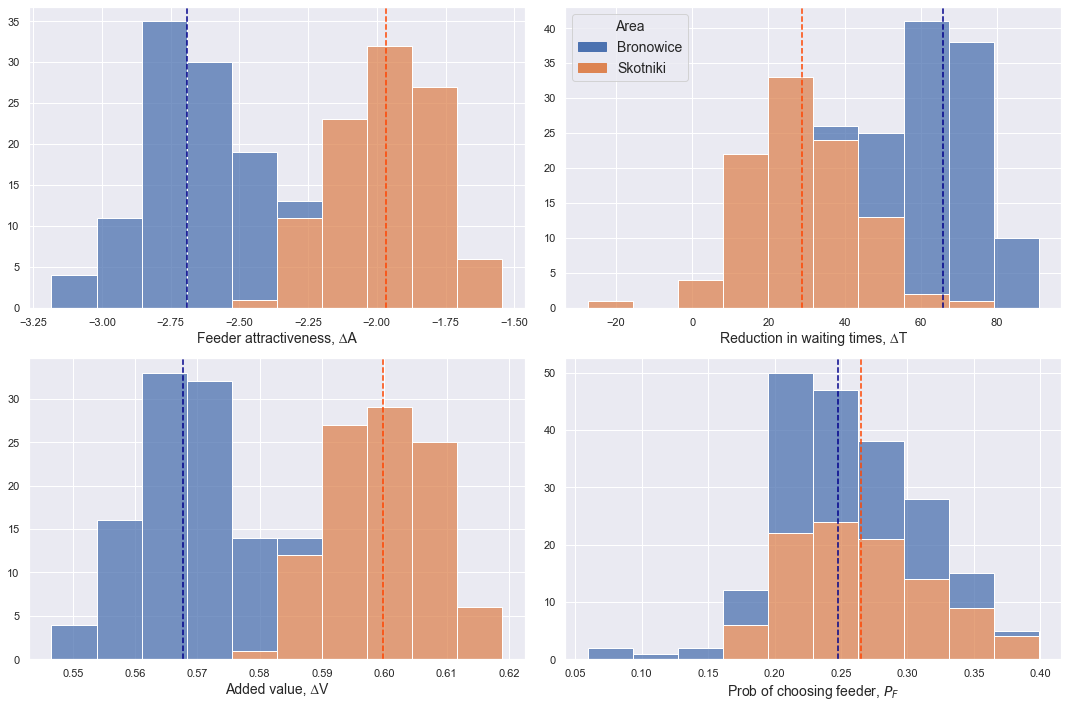

In [27]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
means = avg_sim_res_b_s.groupby('Area').mean()
cols = avg_sim_res_b_s.columns[-4:]   

ys_b = avg_sim_res_b_s[avg_sim_res_b_s['Area'] == 'Bronowice']
ys_s = avg_sim_res_b_s[avg_sim_res_b_s['Area'] == 'Skotniki']
legend_handles = [
    mpatches.Patch(color=sns.color_palette()[0], label='Bronowice'), 
    mpatches.Patch(color=sns.color_palette()[1], label='Skotniki') 
]

for i, (col, a) in enumerate(zip(cols, ax.flat)):
    sns.histplot(data=avg_sim_res_b_s, x=col,  hue='Area', bins=10, ax=a,
                 multiple="stack", edgecolor='white', legend=False)
    a.set_ylabel('')
    a.axvline(means.loc['Bronowice', col], linestyle='--', color="darkblue")
    a.axvline(means.loc['Skotniki', col], linestyle='--', color="orangered")
    if i == 1: 
        a.legend(handles=legend_handles, title='Area', loc='upper left', fontsize=14, title_fontsize=14)
    a.xaxis.label.set_fontsize(14)

# plt.savefig('images/main_indicators.png', dpi=300)
plt.tight_layout()
plt.show()

Calculate mean values (of 100 averages for each sample) for each indicator and evaluate variance

In [32]:
means = avg_sim_res_b_s.groupby('Area').mean()
means = means[means.columns[-4:]]
vars_b = avg_sim_res_b_s.loc[avg_sim_res_b_s['Area'] == 'Bronowice'][avg_sim_res_b_s.columns[-4:]].var()
vars_s = avg_sim_res_b_s.loc[avg_sim_res_b_s['Area'] == 'Skotniki'][avg_sim_res_b_s.columns[-4:]].var()
variances = pd.concat([vars_b, vars_s], axis=1)
variances = variances.T
means.insert(1, 'prob var', variances['Prob of choosing feeder, $P_F$'].values)
means.insert(3, 'reduction in waiting t var', variances['Reduction in waiting times, ∆T'].values)
means.insert(5, 'attractiveness var', variances['Feeder attractiveness, ∆A'].values)

means['added value var'] = variances['Added value, ∆V'].values
means = round(means, 4)
means

,"Feeder attractiveness, ∆A",prob var,"Reduction in waiting times, ∆T",reduction in waiting t var,"Added value, ∆V",attractiveness var,"Prob of choosing feeder, $P_F$",added value var
Area,,,,,,,,
Bronowice,-2.6898,0.0030,65.9044,107.6911,0.5677,0.0340,0.2481,0.0001
Skotniki,-1.9656,0.0027,28.9247,224.9553,0.5997,0.0357,0.2651,0.0001


Evaluation of ExMAS-calculated KPIs

In [37]:
kpis_b = pd.read_csv("results/main_results/kpis_res_b.csv", index_col=0)
kpis_b = kpis_b.T.reset_index(drop=True)
kpis_b = fncs.calc_KPIs(kpis_b)

kpis_s = pd.read_csv("results/main_results/kpis_res_s.csv", index_col=0)
kpis_s = kpis_s.T.reset_index(drop=True)
kpis_s = fncs.calc_KPIs(kpis_s)

kpis_b['Area']='Bronowice'
kpis_s['Area']='Skotniki'
# rename columns to plot
kpis_b.rename(columns={"del_VehHourTrav": r"Vehicle hours travelled, $\Delta T_v$", 
                         "del_PassHourTrav": r"Passenger hours travelled, $\Delta T_p$",
                         "Occupancy": "Occupancy, O"}, inplace=True)
kpis_s.rename(columns={"del_VehHourTrav": r"Vehicle hours travelled, $\Delta T_v$", 
                         "del_PassHourTrav": r"Passenger hours travelled, $\Delta T_p$",
                         "Occupancy": "Occupancy, O"}, inplace=True)
kpis_b_s = pd.concat([kpis_b, kpis_s])

In [38]:
kpis_s

,VehHourTrav,VehHourTrav_ns,PassHourTrav,PassHourTrav_ns,PassUtility,PassUtility_ns,mean_lambda,revenue_s,revenue_ns,Fare_Discount,...,fleet_size_shared,lambda_shared,dtype,_typ,"Vehicle hours travelled, $\Delta T_v$",del_PassUtility,"Occupancy, O","Passenger hours travelled, $\Delta T_p$",del_fleet_size,Area
0,4747,9757,11376,9757,106.99095,117.19050000000001,0.5376285868976719,10244.849999999999,14635.5,-0.3000000000000001,...,4.0,0.5376285868976719,DotMap(),DotMap(),0.513478,0.087034,2.396461,0.165932,0.600000,Skotniki
1,4625,9499,11317,9499,105.8952,114.09900000000002,0.5396012030745239,9973.949999999999,14248.5,-0.3000000000000001,...,3.0,0.5396012030745239,DotMap(),DotMap(),0.513107,0.071901,2.446919,0.191389,0.750000,Skotniki
2,4846,9702,11320,9702,106.87019999999997,116.53200000000001,0.5359251420296313,10187.099999999999,14553.0,-0.3000000000000001,...,5.0,0.5359251420296313,DotMap(),DotMap(),0.500515,0.082911,2.335947,0.166770,0.583333,Skotniki
3,4511,8380,9249,8380,91.413,100.656,0.5123565158676571,8799.0,12570.0,-0.3,...,5.0,0.5123565158676571,DotMap(),DotMap(),0.461695,0.091828,2.050321,0.103699,0.500000,Skotniki
4,4193,8431,10218,8431,92.1819,101.25450000000004,0.5175245098039216,8852.55,12646.5,-0.30000000000000004,...,3.0,0.5175245098039216,DotMap(),DotMap(),0.502669,0.089602,2.436919,0.211956,0.700000,Skotniki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,4354,8925,10148,8925,98.52194999999996,107.20049999999999,0.5383054892601432,9371.25,13387.5,-0.3,...,3.0,0.5383054892601432,DotMap(),DotMap(),0.512157,0.080956,2.330730,0.137031,0.571429,Skotniki
1556,4283,8890,10765,8890,96.72209999999998,106.78499999999998,0.5352560329605651,9334.5,13335.0,-0.3,...,4.0,0.5352560329605651,DotMap(),DotMap(),0.518223,0.094235,2.513425,0.210911,0.428571,Skotniki
1557,4369,8928,10215,8928,99.4566,107.23949999999999,0.558495651108661,9374.4,13392.0,-0.30000000000000004,...,4.0,0.558495651108661,DotMap(),DotMap(),0.510641,0.072575,2.338064,0.144153,0.428571,Skotniki
1558,4121,8629,9757,8629,94.93754999999999,103.6605,0.5502226620484909,9060.449999999999,12943.5,-0.3000000000000001,...,3.0,0.5502226620484909,DotMap(),DotMap(),0.522424,0.084149,2.367629,0.130722,0.571429,Skotniki


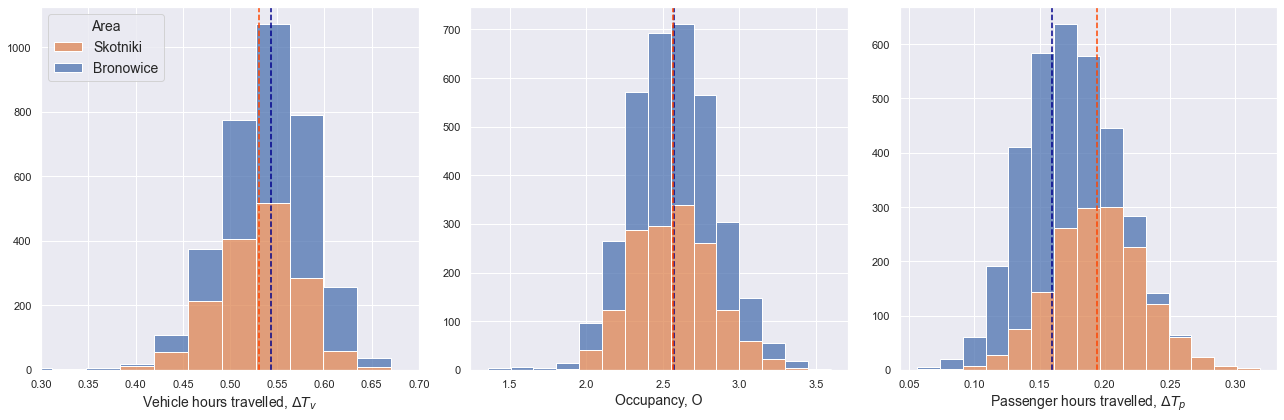

In [42]:
cols = ["Vehicle hours travelled, $\Delta T_v$", 'Occupancy, O', "Passenger hours travelled, $\Delta T_p$"]
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, (col, a) in enumerate(zip(cols, ax.flat)):
    if i == 0:
        a.set_xlim(0.3, 0.7)
        # add legend only to the first subplot
        sns.histplot(data=kpis_b_s, x=col, hue='Area', bins=15, ax=a, 
                     multiple="stack", edgecolor='white', legend=True)
        a.legend(labels=['Skotniki', 'Bronowice'], title='Area', loc='upper left', 
                 fontsize=14, title_fontsize=14)
    else:
        # hide legend for other subplots
        sns.histplot(data=kpis_b_s, x=col, hue='Area', bins=15, ax=a, 
                     multiple="stack", edgecolor='white', legend=False)
    a.axvline(kpis_b[col].mean(), linestyle='--', color="darkblue")
    a.axvline(kpis_s[col].mean(), linestyle='--', color="orangered")
    a.set_ylabel('')
    a.xaxis.label.set_fontsize(14)

# plt.savefig('images/kpis_hists.png', dpi=300)
plt.tight_layout()
plt.show()

In [43]:
df_sum_b = pd.read_csv("results/main_results/sum_res_b.csv", index_col=0)
df_sum_s = pd.read_csv("results/main_results/sum_res_s.csv", index_col=0)

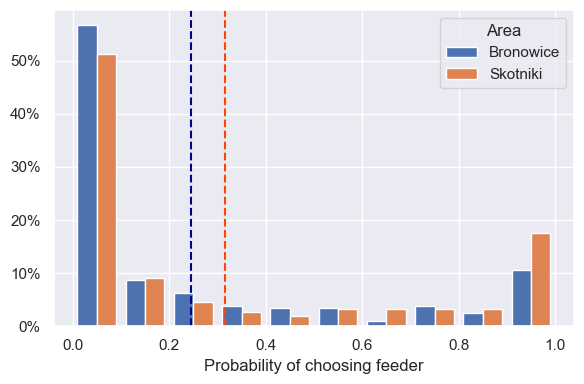

In [ ]:
p_sum_b = df_sum_b.p_SUM
p_sum_s = df_sum_s.p_SUM


plt.figure(dpi=100)
sns.set_theme(style="darkgrid")

# compute weights so that the sum of bar heights for each dataset equals 100%
weights_b = np.ones_like(p_sum_b) * 100 / len(p_sum_b)
weights_s = np.ones_like(p_sum_s) * 100 / len(p_sum_s)

bar_plot = plt.hist([p_sum_b, p_sum_s], bins=10, edgecolor='white',
         label=['Bronowice', 'Skotniki'],
         weights=[weights_b, weights_s])  # normalize to percentages

# print(bar_plot)
plt.axvline(p_sum_b.mean(), linestyle='--', color="darkblue")
plt.axvline(p_sum_s.mean(), linestyle='--', color="orangered")

plt.xlabel('Probability of choosing feeder')
# plt.ylabel('Percentage of data points')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100)) 
plt.legend(title='Area')

# plt.savefig('images/feeder_prob_percent_.png', dpi=300)
plt.tight_layout()
plt.show()

##### Analyse average times for the whole system

In [45]:
avg_ts_b = pd.read_csv("results/main_results/avg_times_b.csv", index_col=0)
avg_ts_s = pd.read_csv("results/main_results/avg_times_s.csv", index_col=0)

In [46]:
avg_ts_b

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,306.886179,307.044872,319.704944,312.762821,296.779146,307.096618,303.952724,305.543062,311.803318,304.877832,...,300.084135,300.330870,306.033019,311.571429,306.466035,287.606280,313.075829,302.721959,318.373618,307.287879
1,319.089431,318.972756,330.291866,328.254808,308.894089,316.841385,311.787660,323.160287,323.641390,314.994337,...,312.468750,319.238916,314.625000,319.935714,317.935229,297.299517,324.154028,310.513428,333.280411,316.494418
2,321.525203,323.330929,332.449761,330.130609,313.057471,319.107085,314.620192,325.062998,326.480253,315.881068,...,315.513622,320.933498,320.616352,321.642063,319.056872,299.139291,327.673776,313.745656,336.801738,320.635566
3,322.951220,325.765224,334.311802,333.612179,313.619869,322.731079,315.516827,326.458533,327.709321,319.635113,...,317.367788,322.125616,322.112421,325.622222,321.018957,302.444444,330.323855,316.439179,338.706161,324.045455
4,324.658943,327.034856,336.021531,334.063702,315.765599,322.446860,317.506811,328.976077,331.433254,319.942152,...,318.404247,323.016010,324.055818,327.036905,322.029621,303.217794,333.578199,317.598341,340.757504,325.886762
5,324.585122,327.753205,337.898006,334.768830,317.150657,324.609662,318.236779,329.330064,333.061295,320.259061,...,319.174760,324.175123,325.589072,328.535556,321.920063,305.085668,335.219747,318.911532,341.473144,326.631180
6,325.022195,327.540785,339.099761,336.452003,319.302299,324.168921,318.042067,331.926874,334.259163,320.122492,...,318.938381,324.284401,327.266903,329.055635,322.703397,304.456763,338.796051,319.360111,342.571485,327.095136
7,326.199628,327.790282,340.418626,337.083139,321.540160,324.107614,319.852312,333.021918,334.756376,319.993308,...,317.746291,324.883099,328.276101,329.315986,323.969183,307.296756,340.810675,320.649289,344.517016,329.456254
8,327.200151,330.053039,341.381271,338.824742,322.012943,325.394306,319.867193,334.818438,335.315437,320.389003,...,317.833053,326.104175,328.551409,330.008566,324.850344,307.863935,341.795633,323.209456,344.304525,329.963972
9,327.102573,330.128072,342.194697,339.358217,322.401206,326.005235,320.514953,335.333901,337.480903,320.877314,...,318.319895,326.756261,329.124961,331.095261,325.443852,308.090455,342.592804,324.483448,344.550117,331.459957


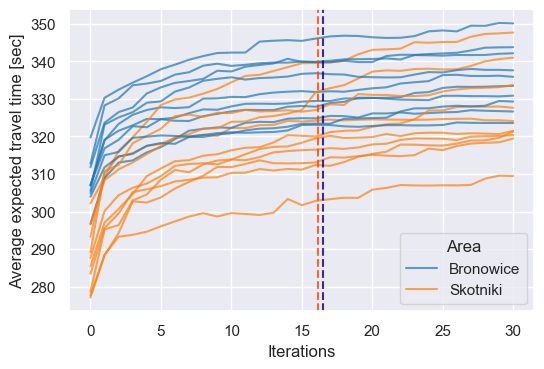

In [48]:
sns.set_theme(style="darkgrid")
plt.figure(dpi=100)

colors = sns.color_palette("tab10") 

for i in range(10):
    tb = avg_ts_b.iloc[:, i]
    ts = avg_ts_s.iloc[:, i]

    plt.plot(tb, color=colors[0], alpha=0.7, label='Bronowice' if i == 0 else "")
    plt.plot(ts, color=colors[1], alpha=0.7, label='Skotniki' if i == 0 else "")

plt.axvline(idx_converged['Bronowice Wielkie'].mean(), color="darkblue", linestyle="--", alpha=0.8)
plt.axvline(idx_converged['Skotniki'].mean(), color="orangered", linestyle="--", alpha=0.8)

plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend(title='Area')
plt.show()

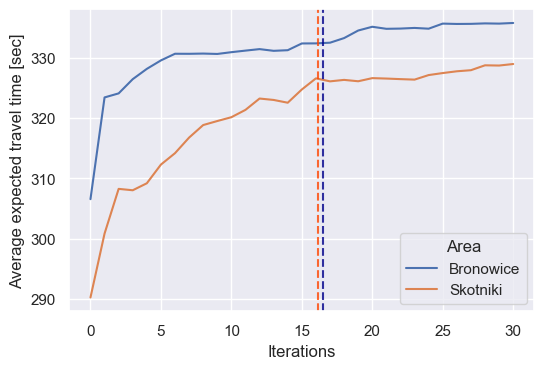

In [ ]:
# average t_expexted after applying MSA for 30 iterations

sns.set_theme(style="darkgrid")
tb = avg_ts_b.iloc[:, 10]
ts = avg_ts_s.iloc[:, 10]

plt.figure(dpi=100)
plt.plot(tb, label='Bronowice')
plt.plot(ts, label='Skotniki')

plt.axvline(idx_converged['Bronowice'].mean(), color="darkblue", linestyle="--", alpha=0.8)
plt.axvline(idx_converged['Skotniki'].mean(), color="orangered", linestyle="--", alpha=0.8)

plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend(title='Area')
# plt.savefig('images/avg_times_10.png', dpi=300)
plt.show()

In [47]:
idx_converged

,Bronowice,Skotniki
0,14,25
1,16,26
2,15,16
3,15,17
4,26,26
...,...,...
95,16,14
96,16,0
97,17,27
98,15,26


In [49]:
idx_converged[idx_converged['Bronowice'] == 0]

,Bronowice,Skotniki
14,0,10
21,0,0
32,0,26
40,0,0
45,0,25


In [318]:
idx_converged[idx_converged['Skotniki'] == 0]

,index,Bronowice Wielkie,Skotniki
15,15,14,0
17,17,13,0
21,21,0,0
23,23,19,0
25,0,19,0
27,2,24,0
31,6,15,0
33,8,21,0
36,11,20,0
40,15,0,0


Travel times for two transport modes: feeder and PT 
<br>avg_ts_sh - average times only for travelers who share trip
<br>avg_ts_pt - average times for travelers using PT

In [50]:
pt_ts_b = pd.read_csv("results/main_results/avg_ts_pt_b.csv", index_col=0)
sh_ts_b = pd.read_csv("results/main_results/avg_ts_sh_b.csv", index_col=0)

pt_ts_s = pd.read_csv("results/main_results/avg_ts_pt_s.csv", index_col=0)
sh_ts_s = pd.read_csv("results/main_results/avg_ts_sh_s.csv", index_col=0)


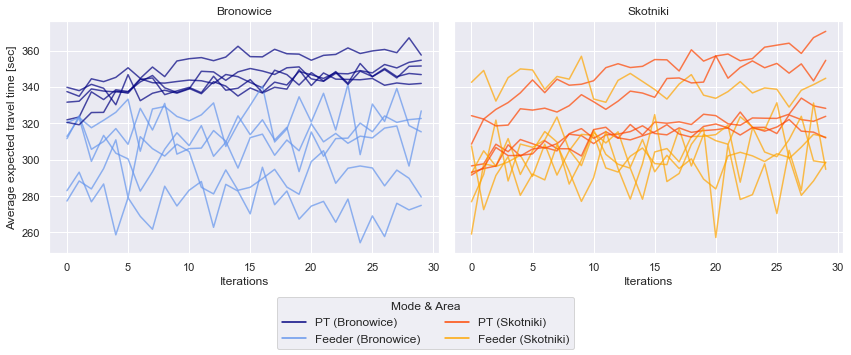

In [52]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

bronowice_pt_color = 'navy'
bronowice_feeder_color = 'cornflowerblue'
skotniki_pt_color = 'orangered'
skotniki_feeder_color = 'orange'

# Bronowice
for i in range(5):  
    ax[0].plot(pt_ts_b.iloc[:, i], color=bronowice_pt_color, alpha=0.7, label='PT' if i == 0 else "")
    ax[0].plot(sh_ts_b.iloc[:, i], color=bronowice_feeder_color, alpha=0.7, label='Feeder' if i == 0 else "")

ax[0].set_title("Bronowice")
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Average expected travel time [sec]')

# Skotniki
for i in range(5): 
    ax[1].plot(pt_ts_s.iloc[:, i], color=skotniki_pt_color, alpha=0.7, label='PT' if i == 0 else "")
    ax[1].plot(sh_ts_s.iloc[:, i], color=skotniki_feeder_color, alpha=0.7, label='Feeder' if i == 0 else "")

ax[1].set_title("Skotniki")
ax[1].set_xlabel('Iterations')

# legend handles
legend_handles = [
    mlines.Line2D([], [], color=bronowice_pt_color, label='PT (Bronowice)'),
    mlines.Line2D([], [], color=bronowice_feeder_color, label='Feeder (Bronowice)'),
    mlines.Line2D([], [], color=skotniki_pt_color, label='PT (Skotniki)'),
    mlines.Line2D([], [], color=skotniki_feeder_color, label='Feeder (Skotniki)')
]

# central legend for both plots
fig.legend(handles=legend_handles, title='Mode & Area', loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

#### Analyse the dependency of main indicators on ASC

In [ ]:
# ! run 5 simulations (N = 5 area samples) for shared trips with varying ASCs [0, 5] for 50 asc values
# Simulations were performed on the processor 3,8 GHz 8-Core Intel Core i7 - the duration is 9893m 46.1s (164.88h or 6.87d)
max_ASC = 5
n = 50
count = 1
total_res = {}
res_b, res_s = {}, {}

for asc in np.linspace(0.00001, max_ASC, n):
    print(count, "ASC", asc)
    count += 1
    res = fncs.simulate_MSA(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, 
                    degree=6, N=5, max_iter=30, ASC=asc, results_period=0)
    
    res_b[asc] = res['Bronowice']['avg_sim_res']
    res_s[asc] = res['Skotniki']['avg_sim_res']

total_res['Bronowice'] = res_b
total_res['Skotniki'] = res_s

In [ ]:
# assign ASC column to combined dataframes

dict_b = total_res['Bronowice'].copy()
combined_df_b = pd.concat(
    [df.assign(ASC=key) for key, df in dict_b.items()], ignore_index=True)
dict_s = total_res['Skotniki'].copy()
combined_df_s = pd.concat(
    [df.assign(ASC=key) for key, df in dict_s.items()], ignore_index=True)

In [ ]:
# save to CSV
# combined_df_b.to_csv('results/main_results/res_asc_5indicators_b.csv', index=False)
# combined_df_s.to_csv('results/main_results/res_asc_5indicators_s.csv', index=False)

In [ ]:
# read files, plot graphs
b_df = pd.read_csv("results/main_results/5_res_asc_indicators_b.csv")
s_df = pd.read_csv("results/main_results/5_res_asc_indicators_s.csv")

In [55]:
b_df['Area']='Bronowice'
s_df['Area']='Skotniki'
b_s_df = pd.concat([b_df, s_df])

b_s_df['Feeder attractiveness, ∆A'] = b_s_df['u_PT_OD'] - b_s_df['u_SUM_OD']
b_s_df['Reduction in waiting times, ∆T'] = b_s_df['tw_PT_OD'] - b_s_df['tw_PT_HD']

mu = -0.1
b_s_df['Added value, ∆V'] = np.log(np.exp(mu * b_s_df['u_PT_OD']) +\
                               np.exp(mu * b_s_df['u_SUM_OD'])) - mu * b_s_df['u_PT_OD']
b_s_df['Probability of choosing feeder, $P_F$'] = b_s_df['p_SUM']

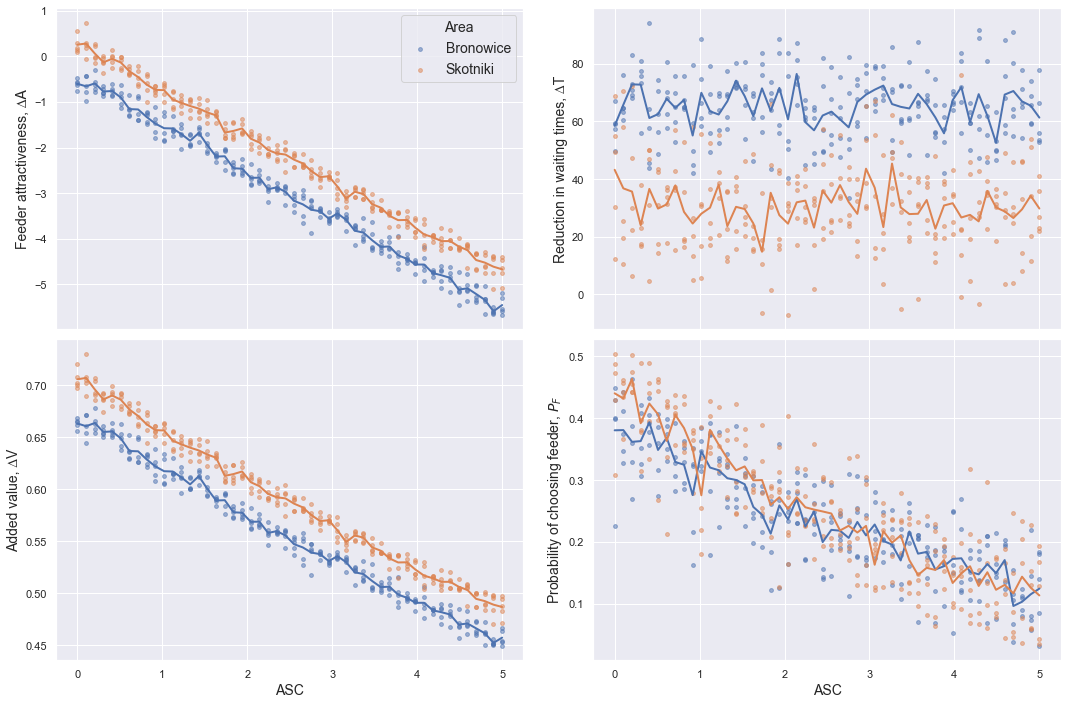

In [57]:
sns.set_theme(style="darkgrid")

max_ASC = 5
n = 50
cols = b_s_df.columns[-4:]

xs = list(np.linspace(0, max_ASC, n))
xs_scatter = b_df['ASC'].values
ys_b = b_s_df[b_s_df['Area'] == 'Bronowice']
ys_s = b_s_df[b_s_df['Area'] == 'Skotniki']

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)  # Share only x-axis

lines = []
for idx, (col, ax) in enumerate(zip(cols, axes.flat)):  # Flatten axes array for easy looping
    ax.scatter(xs_scatter, ys_b[col].values, alpha=0.5, s=15)
    ax.scatter(xs_scatter, ys_s[col].values, alpha=0.5, s=15)
    b_line, = ax.plot(xs, ys_b.groupby(by=['ASC'])[col].mean().values, label='Bronowice Wielkie', linewidth=2)
    s_line, = ax.plot(xs, ys_s.groupby(by=['ASC'])[col].mean().values, label='Skotniki', linewidth=2)
    
    ax.set_ylabel(col, fontsize=14)

    # set xlabel only on the bottom row of subplots
    if idx >= 2:
        ax.set_xlabel("ASC", fontsize=14)
    
    if idx == 0:  # Add legend only in the first subplot
        lines.extend([b_line, s_line])
        ax.legend(labels=['Bronowice', 'Skotniki'], title='Area', loc='upper right', 
                  fontsize=14, title_fontsize=14)

fig.subplots_adjust(hspace=0.03, wspace=0.15)
# plt.savefig('images/asc_vs_indicators_tight.png', dpi=300)
plt.show()